In [46]:
import os
import json
from copy import deepcopy
from collections import defaultdict
from utils import adjust_zero
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
kernels = os.listdir("./dumps_dag/")
kernels

['corr_kernel',
 'mm',
 'Convolution2D_kernel',
 'Convolution3D_kernel',
 'mm2_kernel1',
 'naive_copy',
 'mt',
 'memset2',
 'atax_kernel1',
 'naive_transpose',
 'mm2metersKernel',
 'FFC',
 'gemm',
 'memset1',
 'reduce_kernel',
 'atax_kernel2',
 'syrk_kernel',
 'fdtd_kernel1',
 'MatVecMulCoalesced2',
 'spmv_jds_naive',
 'syr2k_kernel',
 'MatVecMulCoalesced1',
 'bicgKernel1',
 'mvt_kernel1',
 'naive_kernel',
 'MatVecMulUncoalesced1',
 'covar_kernel',
 'mm3_kernel1',
 'mean_kernel',
 'fdtd_kernel3',
 'std_kernel',
 'gesummv_kernel',
 'fdtd_kernel2',
 'coalesced_gemm']

In [4]:
def construct_table(profiling_results,kernel,d2h,h2d,workdim,data=None):
    if not data:
        data = defaultdict(list)
    dev_dict = {0:"cpu",10:"gpu"}
    for result in profiling_results:
        with open(os.path.join("./dumps_dag",kernel,result)) as f:
            timestamps = json.load(f)
        launch_params = result[:-5].split('_')
        #print launch_params
        m1 = n1 = p1 = dataset = global_work_size = int(launch_params[-3])
        
        device = int(launch_params[-4])
        local_work_size = int(launch_params[-2])
        run_number = int(launch_params[-1])
        h2d_num_bytes = sum([eval(buff_size) for buff_size in h2d])
        d2h_num_bytes = sum([eval(buff_size) for buff_size in d2h])
        timestamps,total_time = adjust_zero(timestamps)
        
        key = timestamps.keys()[0]
        
        
        try:
            h2d_time = timestamps[key]["write"]["device_end"] - timestamps[key]["write"]["device_start"]
        except:
            h2d_time = None
        
        try:
            d2h_time = timestamps[key]["read"]["device_end"] - timestamps[key]["read"]["device_start"]
        except:
            d2h_time = None
        
        try:
            exec_time = timestamps[key]["nd_range"]["device_end"] - timestamps[key]["nd_range"]["device_start"]
        except:
            exec_time = None
        
        
        data["kernel"].append(kernel)
        data["work_dim"].append(workdim)
        data["global_work_size"].append(global_work_size**(workdim))
        data["local_work_size"].append(local_work_size**(workdim))
        data["run"].append(run_number)
        data["device"].append(dev_dict[device])
        
        data["h2d_bytes"].append(h2d_num_bytes)
        data["d2h_bytes"].append(d2h_num_bytes)
        data["h2d_time"].append(h2d_time)
        data["d2h_time"].append(d2h_time)
        data["exec_time"].append(exec_time)
        data["total_time"].append(total_time)
        
    return data

In [5]:
data = None
kernels = os.listdir("./dumps_dag/")

for kernel in kernels:
    #print(kernel)
    try:
        profiling_results = os.listdir(os.path.join("./dumps_dag",kernel))

        with open("../database/info/{}.json".format(kernel)) as f:
            source_info = json.load(f)

        h2d = []
        d2h = []
        workdim = source_info["workDimension"]

        for key in ["inputBuffers",'ioBuffers']:
            if key in source_info:
                for buff in source_info[key]:
                    h2d.append(buff['size'])

        for key in ["outputBuffers",'ioBuffers']:
            if key in source_info:
                for buff in source_info[key]:
                    d2h.append(buff['size'])
        data = construct_table(profiling_results,kernel,d2h,h2d,workdim,data)
    except KeyboardInterrupt:
        raise
    except IOError:
        continue
    except Exception as e:
        print(kernel,e)
        continue

('memset2', TypeError("unsupported operand type(s) for -=: 'float' and 'NoneType'",))
('memset1', TypeError("unsupported operand type(s) for -=: 'float' and 'NoneType'",))


In [6]:
df = pd.DataFrame.from_dict(data)
a = df.groupby(['kernel','global_work_size','local_work_size','device'])


In [7]:
grouped_data = defaultdict(dict)

for group in a:
    kernel,glob,loc,dev = group[0]
    data = group[1].mean()
    #print(kernel,glob,loc,dev)
    #print(data.keys())
    for key in ['d2h_time','h2d_time','exec_time','total_time']:
        grouped_data[(kernel,glob,loc)][key+"_"+dev] = data[key]
    for key in ['d2h_bytes','h2d_bytes','work_dim']:
        grouped_data[(kernel,glob,loc)][key] = data[key]
    
    

In [8]:
new_data = defaultdict(list)
for key,timing in grouped_data.items():    
    if 'total_time_gpu' in timing and 'total_time_cpu' in timing:
        kernel,glob,loc = key
        new_data["kernel"].append(kernel)
        new_data["global_work_size"].append(glob)
        new_data["local_work_size"].append(loc)

        for key1,val in timing.items():
            new_data[key1].append(val)
            
    else:
        print(key,timing)


(('bicgKernel1', 512, 64), {'exec_time_gpu': 0.0005009651184082031, 'd2h_time_gpu': 3.147125244140625e-06, 'h2d_bytes': 1024.0, 'total_time_gpu': 0.00057525634765625, 'h2d_time_gpu': 1.8215179443359376e-05, 'd2h_bytes': 512.0, 'work_dim': 1.0})
(('Convolution3D_kernel', 1048576, 4096), {'h2d_bytes': 1073741824.0, 'exec_time_cpu': 0.0014839649200439453, 'total_time_cpu': 4.013317084312439, 'd2h_time_cpu': 2.4141146421432493, 'd2h_bytes': 1073741824.0, 'h2d_time_cpu': 1.5973314046859741, 'work_dim': 2.0})
(('bicgKernel1', 512, 8), {'exec_time_gpu': 0.0002749443054199219, 'd2h_time_gpu': 3.0040740966796874e-06, 'h2d_bytes': 1024.0, 'total_time_gpu': 0.0003520965576171875, 'h2d_time_gpu': 1.9121170043945313e-05, 'd2h_bytes': 512.0, 'work_dim': 1.0})
(('bicgKernel1', 512, 16), {'exec_time_gpu': 0.0003509998321533203, 'd2h_time_gpu': 3.0040740966796874e-06, 'h2d_bytes': 1024.0, 'total_time_gpu': 0.00043230056762695314, 'h2d_time_gpu': 1.9121170043945313e-05, 'd2h_bytes': 512.0, 'work_dim': 1

In [9]:
# for k,v in new_data.items():
#     print(k,len(v))
df = pd.DataFrame.from_dict(new_data)
df.head()

,d2h_bytes,d2h_time_cpu,d2h_time_gpu,exec_time_cpu,exec_time_gpu,global_work_size,h2d_bytes,h2d_time_cpu,h2d_time_gpu,kernel,local_work_size,total_time_cpu,total_time_gpu,work_dim
0,32768.0,2.288818e-05,0.000023,0.000415,0.000021,32768,32768.0,0.000118,0.000024,naive_kernel,64,0.000908,0.000170,3.0
1,4194304.0,2.417946e-03,0.003681,0.001222,0.001743,4194304,8388609.0,0.011572,0.007313,fdtd_kernel2,16,0.015644,0.012778,2.0
2,16384.0,1.177788e-05,0.000013,0.000202,0.000036,16384,16384.0,0.000081,0.000012,naive_transpose,16,0.000633,0.000130,2.0
3,65536.0,5.128384e-05,0.000042,0.000549,0.000022,65536,65536.0,0.000228,0.000045,naive_copy,16,0.001158,0.000240,2.0
4,64.0,7.629395e-07,0.000003,0.000018,0.000068,64,8192.0,0.000068,0.000026,MatVecMulUncoalesced1,64,0.000433,0.000271,1.0


In [10]:

def extract_feature_vector(file):
    feats = []
    with open(os.path.join("../database/features/",file)) as f:
        lines = f.readlines()
        start = False
        end = False
        for line in lines:
            line = line.strip()
            if start:
                a = line.split()
                if a[0]=='instsPerBlock:':
                    break
                val = float(a[1])
                feats.append(val)
                
            elif line == '---':
                start = True
    return feats

In [11]:
feature_files = os.listdir("../database/features/")
records = []
for feat_file in feature_files:
    kernel = feat_file[:-5]
    features = extract_feature_vector(feat_file)
    record = [kernel] + features
    records.append(record)

columns = ["f_{}".format(i) for i in range(len(records[0])-1)]
columns = ["kernel"] + columns
df_feat = pd.DataFrame.from_records(records,columns=columns)
df_feat.head()

,kernel,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79
0,corr_kernel,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,...,1.0,65.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
1,atax_kernel1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,27.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0
2,Convolution3D_kernel,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,...,16.0,222.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
3,bicgKernel1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,1.0,29.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0
4,naive_copy,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
feats = {}
for kernel in np.unique(df['kernel']):
    feats[kernel] = df_feat[df_feat['kernel']==kernel].values[0][1:]
    

for kernel in np.unique(df['kernel']):
    sim = np.dot(feats[kernel],feats['gemm'])/np.linalg.norm(feats[kernel])/np.linalg.norm(feats['gemm'])
    if sim  > 0.98:
        local = df[df['kernel'] == kernel]
        local = local[local['work_dim']==2]
        local = local[local['local_work_size']>=256]
        spdups = []
        sizes = []
        for sz in [64,128,256,512,1024,2048]:
            avg = 0
            ct = 0
            local_size = local[local['global_work_size']==sz*sz]
            
            cpu = np.array(local_size['total_time_cpu'])
            gpu = np.array(local_size['total_time_gpu'])
            for i in range(len(local_size)):
                avg += cpu[i]/gpu[i]
                ct+=1
            if ct !=0:
                #print kernel, sim, sz
                #print 'mean speedup ',avg/ct,"\n"
                spdups.append(avg/ct)
                sizes.append(sz)
        if len(sizes):
            plt.figure()
            plt.plot(sizes,spdups)
            plt.plot(sizes,[1]*len(sizes))
            plt.title("2D kernel - {} ... similarity with gemm - {}".format(kernel,sim))
            plt.xlabel('sqrt(globalworksize)')
            plt.ylabel('tcpu/tgpu')
        

KeyError: 'gemm'

In [13]:
sample = 'mm3_kernel1'
mm3_kernel_df = df[df['kernel'] == sample][['global_work_size','local_work_size','total_time_gpu','total_time_cpu']]
mm3_kernel_df.groupby(['global_work_size','local_work_size']).mean()

total_time_gpu  total_time_cpu
global_work_size local_work_size                                
1024             16                     0.000127        0.000529
                 64                     0.000133        0.000502
                 256                    0.000137        0.000484
                 1024                   0.000141        0.000500
4096             16                     0.000182        0.000547
                 64                     0.000162        0.000559
                 256                    0.000181        0.000545
                 1024                   0.000164        0.000534
16384            16                     0.000500        0.000864
                 64                     0.000313        0.000720
                 256                    0.000258        0.000697
                 1024                   0.000251        0.000786
65536            16                     0.002788        0.002366
                 64                     0.001309        0.001261
                 256                    0.001005        0.001492
                 1024                   0.000923        0.001441
262144           16                     0.019518        0.004172
                 64                     0.007658        0.004155
                 256                    0.005135        0.004384
                 1024                   0.004215        0.004368
1048576          16                     0.170661        0.021419
                 64                     0.053996        0.021467
                 256                    0.033046        0.021552
                 1024                   0.030265        0.021700
4194304          16                     1.353204        0.142541
                 64                     0.429436        0.142693
                 256                    0.253185        0.142418
                 1024                   0.222216        0.142631

In [31]:
#These are highly uncoalesced kernels with high feature similarity to coalesced gemm
df_temp = df.drop(np.argwhere(np.array(df['kernel']=='gemm')).reshape((-1)))
df_temp = df_temp.drop(np.argwhere(np.array(df['kernel']=='syrk_kernel')).reshape((-1)))
df_temp = df_temp.drop(np.argwhere(np.array(df['kernel']=='syr2k_kernel')).reshape((-1)))
df = df_temp

In [32]:
np.unique(df['kernel'])

array(['Convolution2D_kernel', 'Convolution3D_kernel', 'FFC',
       'MatVecMulCoalesced1', 'MatVecMulCoalesced2',
       'MatVecMulUncoalesced1', 'atax_kernel1', 'atax_kernel2',
       'bicgKernel1', 'corr_kernel', 'covar_kernel', 'fdtd_kernel1',
       'fdtd_kernel2', 'fdtd_kernel3', 'gesummv_kernel', 'mean_kernel',
       'mm', 'mm2_kernel1', 'mm2metersKernel', 'mm3_kernel1', 'mt',
       'mvt_kernel1', 'naive_copy', 'naive_kernel', 'naive_transpose',
       'reduce_kernel', 'std_kernel'], dtype=object)

In [33]:
df2 = df.set_index('kernel').join(df_feat.set_index('kernel'))
# df2 = df.groupby(['kernel','device','global_work_size','local_work_size']).mean()
# df2 = df2.drop(columns=['run'])
df2.to_csv('profiled_data.csv')
df2.head()

,d2h_bytes,d2h_time_cpu,d2h_time_gpu,exec_time_cpu,exec_time_gpu,global_work_size,h2d_bytes,h2d_time_cpu,h2d_time_gpu,local_work_size,...,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79
kernel,,,,,,,,,,,,,,,,,,,,,
Convolution2D_kernel,1048576.0,0.001908,0.001726,0.002781,0.000143,1048576,1048576.0,0.001880,0.000808,1024,...,9.0,84.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Convolution2D_kernel,4096.0,0.000004,0.000005,0.000070,0.000035,4096,4096.0,0.000035,0.000004,256,...,9.0,84.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Convolution2D_kernel,262144.0,0.000442,0.000164,0.000239,0.000077,262144,262144.0,0.000561,0.000173,64,...,9.0,84.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Convolution2D_kernel,262144.0,0.000520,0.000168,0.000274,0.000050,262144,262144.0,0.000558,0.000173,256,...,9.0,84.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Convolution2D_kernel,4096.0,0.000004,0.000005,0.000153,0.000034,4096,4096.0,0.000033,0.000004,16,...,9.0,84.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [34]:
# from math import floor
# for kernel in np.unique(df[df['work_dim']==3]['kernel']):
#    print kernel.replace("_","\\_")," & ",floor(np.min(df[df['kernel']==str(kernel)]['d2h_bytes'])/1024),"-",floor(np.max(df[df['kernel']==str(kernel)]\
#                                                                                         ['d2h_bytes'])/1024)," & ",\
# floor(np.min(df[df['kernel']==str(kernel)]['h2d_bytes'])/1024),"-",floor(np.max(df[df['kernel']==str(kernel)]['h2d_bytes'])/1024)," \\\\",

In [35]:
# c = 0
# for kernel in np.unique(df[df['work_dim']==3]['kernel']):
#    print "& ",kernel.replace("_","\\_")," & ","NVIDIA"," \\\\",
#    c+=1
    
# print "\n\n",c

In [36]:
y_df = df2[['d2h_time_cpu','h2d_time_cpu','exec_time_cpu','total_time_cpu',\
            'd2h_time_gpu','h2d_time_gpu','exec_time_gpu','total_time_gpu']]
x_df = df2.drop(columns =['d2h_time_cpu','h2d_time_cpu','exec_time_cpu','total_time_cpu',\
                          'd2h_time_gpu','h2d_time_gpu','exec_time_gpu','total_time_gpu'] )
x_df.head()

,d2h_bytes,global_work_size,h2d_bytes,local_work_size,work_dim,f_0,f_1,f_2,f_3,f_4,...,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79
kernel,,,,,,,,,,,,,,,,,,,,,
Convolution2D_kernel,1048576.0,1048576,1048576.0,1024,2.0,0.0,22.0,0.0,0.0,0.0,...,9.0,84.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Convolution2D_kernel,4096.0,4096,4096.0,256,2.0,0.0,22.0,0.0,0.0,0.0,...,9.0,84.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Convolution2D_kernel,262144.0,262144,262144.0,64,2.0,0.0,22.0,0.0,0.0,0.0,...,9.0,84.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Convolution2D_kernel,262144.0,262144,262144.0,256,2.0,0.0,22.0,0.0,0.0,0.0,...,9.0,84.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Convolution2D_kernel,4096.0,4096,4096.0,16,2.0,0.0,22.0,0.0,0.0,0.0,...,9.0,84.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [73]:
transformer_kernels = ['coalesced_gemm','coalesced_transpose','softmax','empty']
x_transformer = []
N=256
W=256
Q=256



for kernel in transformer_kernels:
    try:
        feature = list(df_feat[df_feat['kernel']==kernel].values[0,1:])
    except:
        feature = list(np.zeros(80,))
    
    with open("../dag_info/dag_transformer/info/{}.json".format(kernel)) as f:
            source_info = json.load(f)

    h2d = []
    d2h = []
    workdim = source_info["workDimension"]

    for key in ["inputBuffers",'ioBuffers']:
        if key in source_info:
            for buff in source_info[key]:
                h2d.append(buff['size'])

    for key in ["outputBuffers",'ioBuffers']:
        if key in source_info:
            for buff in source_info[key]:
                d2h.append(buff['size'])
    
    if kernel == 'coalesced_gemm':
        for m1,n1,p1 in [(N,Q,W),(N,N,Q),(N,Q,N),(N,W,Q)]:
            h2d_bytes = sum([eval(buff_size) for buff_size in h2d])
            d2h_bytes = sum([eval(buff_size) for buff_size in d2h])
            x_transformer.append([kernel,d2h_bytes,m1*n1,h2d_bytes,32**(workdim),workdim]+feature)


    elif kernel == 'coalesced_transpose':
        for m1,n1 in [(N,Q)]:
            h2d_bytes = sum([eval(buff_size) for buff_size in h2d])
            d2h_bytes = sum([eval(buff_size) for buff_size in d2h])
            x_transformer.append([kernel,d2h_bytes,m1*n1,h2d_bytes,32**(workdim),workdim]+feature)
    
    elif kernel == 'softmax':
        for r1,c1 in [(N,N)]:
            h2d_bytes = sum([eval(buff_size) for buff_size in h2d])
            d2h_bytes = sum([eval(buff_size) for buff_size in d2h])
            x_transformer.append([kernel,d2h_bytes,m1*n1,h2d_bytes,32**(workdim),workdim]+feature)
    
    elif kernel == 'empty':
        for n1,w1,q1 in [(N,W,Q)]:
            h2d_bytes = sum([eval(buff_size) for buff_size in h2d])
            d2h_bytes = sum([eval(buff_size) for buff_size in d2h])
            x_transformer.append([kernel,d2h_bytes,1,h2d_bytes,1,workdim]+feature)
            
            
x_transformer = np.array(x_transformer)
x_transformer
    

array([['coalesced_gemm', '65536', '65536', '131072', '1024', '2', '0.0',
        '5.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '9.0', '2.0',
        '0.0', '0.0', '1.0', '0.0', '0.0', '3.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '4.0', '3.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '4.0', '4.0', '0.0', '3.0', '0.0',
        '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '2.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '8.0', '0.0', '10.0', '4.0', '4.0',
        '27.0', '77.0', '2.0', '13.0', '0.0', '4.0', '0.0', '41.0',
        '0.0', '0.0', '0.0', '5.0', '1.0', '0.0', '0.0', '0.0'],
       ['coalesced_gemm', '65536', '65536', '131072', '1024', '2', '0.0',
        '5.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '9.0', '2.0',
        '0.0', '0.0', '1.0', '0.0', '0.0', '3.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '4.0', '3.0', '0.0', '0.0', '0.0',
        

In [38]:
x = x_df.values
y = y_df.values
x.shape,y.shape

((731, 85), (731, 8))

In [39]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=43)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((584, 85), (147, 85), (584, 8), (147, 8))

In [40]:
# y_df = df2[['d2h_time_cpu','h2d_time_cpu','exec_time_cpu','total_time_cpu',\
#             'd2h_time_gpu','h2d_time_gpu','exec_time_gpu','total_time_gpu']]

var1 = 7
var2 = 3

y_speedups_test = y_test[:,var1]/y_test[:,var2]   #total_time_cpu/total_time_gpu
y_speedups_train = y_train[:,var1]/y_train[:,var2]    #total_time_cpu/total_time_gpu


In [41]:

class MLmodule(object):
    def __init__(self,num_bins):
        self.models = [XGBClassifier(n_estimators=100,max_depth=10) for _ in range(3)]
        self.num_bins = num_bins
        self.bins = []
        
    def bin_hist(self,y_speedups_train,y_speedups_test,N_BINS,title=None):
        plt.figure()
        if title:
            plt.title(title)
        plt.xlabel("Ratio")
        plt.ylabel("Number of Items")
        n,bins,_ = plt.hist(np.concatenate([y_speedups_train,y_speedups_test]),bins=N_BINS)
        bin_size = 0
        for i in range(bins.shape[0]-1):
            #print "Bin [{} - {}] => Num elements {}".format(bins[i],bins[i+1],n[i])
            bin_size += bins[i+1]-bins[i]

        bin_size /= (bins.shape[0]-1)

        y_sp_train_class = []
        y_sp_test_class = []


        for spdup in y_speedups_train:
            found=False
            for i in range(bins.shape[0]-1):
                if spdup >= bins[i]-1e-4 and spdup <= bins[i+1]+1e-4:
                    y_sp_train_class.append(i)
                    found=True
                    break
            assert found,spdup

        for spdup in y_speedups_test:
            found=False
            for i in range(bins.shape[0]-1):
                if spdup >= bins[i]-1e-4 and spdup <= bins[i+1]+1e-4:
                    y_sp_test_class.append(i)
                    found=True
                    break
            assert found,spdup

        y_sp_train_class = np.array(y_sp_train_class)
        y_sp_test_class = np.array(y_sp_test_class)
        
        return y_sp_train_class,y_sp_test_class,bins
    
    def train(self,x_train,y_train,x_test,y_test):
        # y is in this format - [['d2h_time_cpu','h2d_time_cpu','exec_time_cpu','total_time_cpu',\
        #                       'd2h_time_gpu','h2d_time_gpu','exec_time_gpu','total_time_gpu']]
        
        ##1 tcpu/tgpu
        spdups_train = y_train[:,3]/y_train[:,7]
        spdups_test = y_test[:,3]/y_test[:,7]
        y_sp_train_class,y_sp_test_class,bins = self.bin_hist(spdups_train,spdups_test,self.num_bins[0],\
                                                              "Tcpu/TGpu Histogram")
        self.bins.append(bins)
        model = self.models[0]
        model.fit(x_train,y_sp_train_class)
        y_pred = model.predict(x_test)
        
        time_preds = np.array([0.5*(bins[y_pred[i]+1]+bins[y_pred[i]])*y_test[i,7] for i in range(len(y_pred))])
        time_act = y_test[:,3]
        print "Mean relative binning error - ", 100*np.mean(np.abs(y_pred-y_sp_test_class)/(y_sp_test_class+1))
        print "% error in time pred (tcpu/tgpu) - ",100*np.mean(np.abs(time_preds-time_act)/time_act)

        
        ##2 td2h/tgpu
        spdups_train = y_train[:,4]/y_train[:,7]
        spdups_test = y_test[:,4]/y_test[:,7]
        y_sp_train_class,y_sp_test_class,bins = self.bin_hist(spdups_train,spdups_test,self.num_bins[1],\
                                                              "Td2h/TGpu Histogram")
        self.bins.append(bins)
        model = self.models[1]
        model.fit(x_train,y_sp_train_class)
        y_pred = model.predict(x_test)
        
        time_preds = np.array([0.5*(bins[y_pred[i]+1]+bins[y_pred[i]])*y_test[i,7] for i in range(len(y_pred))])
        time_act = y_test[:,4]
        print "Mean relative binning error - ", 100*np.mean(np.abs(y_pred-y_sp_test_class)/(y_sp_test_class+1))
        print "% error in time pred (td2h/tgpu) - ",100*np.mean(np.abs(time_preds-time_act)/time_act)

        
        ##3 th2d/tgpu
        spdups_train = y_train[:,5]/y_train[:,7]
        spdups_test = y_test[:,5]/y_test[:,7]
        y_sp_train_class,y_sp_test_class,bins = self.bin_hist(spdups_train,spdups_test,self.num_bins[2],\
                                                              "Th2d/TGpu Histogram")
        self.bins.append(bins)
        model = self.models[2]
        model.fit(x_train,y_sp_train_class)
        y_pred = model.predict(x_test)
        
        time_preds = np.array([0.5*(bins[y_pred[i]+1]+bins[y_pred[i]])*y_test[i,7] for i in range(len(y_pred))])
        time_act = y_test[:,5]
        print "Mean relative binning error - ", 100*np.mean(np.abs(y_pred-y_sp_test_class)/(y_sp_test_class+1))
        print "% error in time pred (th2d/tgpu) - ",100*np.mean(np.abs(time_preds-time_act)/time_act)
        
    def predict(self,x):
        speedup = self.model[0].predict(x)
        pass

        

/home/anirban/Tools/python/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Mean relative binning error -  3.4013605442176873
% error in time pred (tcpu/tgpu) -  16.51552148653756


/home/anirban/Tools/python/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Mean relative binning error -  3.4013605442176873
% error in time pred (td2h/tgpu) -  21.41450343726552


/home/anirban/Tools/python/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Mean relative binning error -  8.843537414965986
% error in time pred (th2d/tgpu) -  26.574438110747444


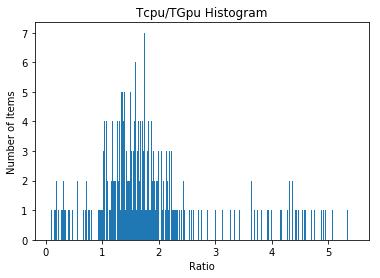

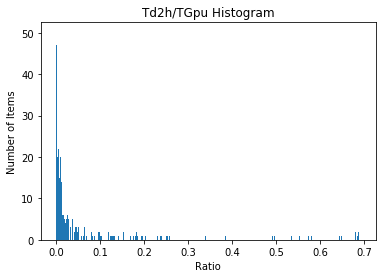

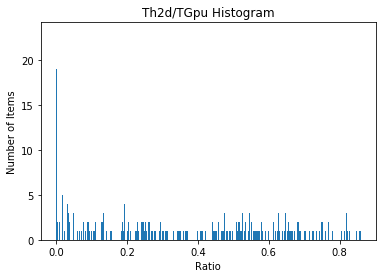

In [42]:
module = MLmodule(num_bins=[1000,1000,1000])
module.train(x_train,y_train,x_test,y_test)

In [84]:
from sklearn.linear_model import LinearRegression as lrg
d2h_model = lrg()
h2d_model = lrg()

data_transfer_df = df2[["d2h_bytes","h2d_bytes","d2h_time_gpu","h2d_time_gpu","d2h_time_cpu","h2d_time_cpu"]]

data_transfer_df = data_transfer_df.astype({'d2h_bytes': 'int32','h2d_bytes': 'int32'})

d2h_df = data_transfer_df[["d2h_bytes","d2h_time_gpu"]].groupby('d2h_bytes')
d2h_data_gpu = []
for item in d2h_df:
    d2h_data_gpu.append([item[0],item[1]["d2h_time_gpu"].mean()])
d2h_data_gpu = np.array(d2h_data_gpu)

d2h_df = data_transfer_df[["d2h_bytes","d2h_time_cpu"]].groupby('d2h_bytes')
d2h_data_cpu = []
for item in d2h_df:
    d2h_data_cpu.append([item[0],item[1]["d2h_time_cpu"].mean()])
d2h_data_cpu = np.array(d2h_data_cpu)


h2d_df = data_transfer_df[["h2d_bytes","h2d_time_gpu"]].groupby('h2d_bytes')
h2d_data_gpu = []
for item in h2d_df:
    h2d_data_gpu.append([item[0],item[1]["h2d_time_gpu"].mean()])
h2d_data_gpu = np.array(h2d_data_gpu)

h2d_df = data_transfer_df[["h2d_bytes","h2d_time_cpu"]].groupby('h2d_bytes')
h2d_data_cpu = []
for item in h2d_df:
    h2d_data_cpu.append([item[0],item[1]["h2d_time_cpu"].mean()])
h2d_data_cpu = np.array(h2d_data_cpu)


# plt.figure()
# plt.title("Device to Host")
# plt.xlabel("Data in bytes")
# plt.ylabel("Time in seconds")
# plt.plot(d2h_data[:,0],d2h_data[:,1])
# d2h_model.fit(d2h_data[:,0].reshape([-1,1]).astype(np.float),d2h_data[:,1].astype(np.float))
# print d2h_model.score(d2h_data[:,0].reshape([-1,1]).astype(np.float),d2h_data[:,1].astype(np.float))


# plt.figure()
# plt.title("Host to Device")
# plt.xlabel("Data in bytes")
# plt.ylabel("Time in seconds")
# plt.plot(h2d_data[:,0],h2d_data[:,1])
# h2d_model.fit(h2d_data[:,0].reshape([-1,1]).astype(np.float),h2d_data[:,1].astype(np.float))
# print h2d_model.score(h2d_data[:,0].reshape([-1,1]).astype(np.float),h2d_data[:,1].astype(np.float))


In [87]:
for data in h2d_data_cpu:
    print "{} bytes -> {} act seconds  ".format(data[0],data[1])
    
def get_nearest_time(data,sample):
    return data[np.argmin(np.abs(data[:,0]-sample))][1]

get_nearest_time(h2d_data_cpu,12800),get_nearest_time(d2h_data_cpu,29184)

64.0 bytes -> 4.17709350586e-05 act seconds  
128.0 bytes -> 3.25584411621e-05 act seconds  
256.0 bytes -> 3.56356302897e-05 act seconds  
512.0 bytes -> 3.91006469727e-05 act seconds  
1024.0 bytes -> 1.21763774327e-05 act seconds  
1056.0 bytes -> 3.72171401978e-05 act seconds  
1088.0 bytes -> 4.7222773234e-05 act seconds  
2048.0 bytes -> 4.2399764061e-05 act seconds  
2049.0 bytes -> 4.01377677917e-05 act seconds  
2080.0 bytes -> 5.69820404053e-05 act seconds  
3072.0 bytes -> 4.6124458313e-05 act seconds  
3104.0 bytes -> 5.72144985199e-05 act seconds  
3136.0 bytes -> 5.00082969666e-05 act seconds  
4096.0 bytes -> 3.77016408103e-05 act seconds  
4160.0 bytes -> 5.68442874485e-05 act seconds  
4224.0 bytes -> 6.89571554011e-05 act seconds  
8192.0 bytes -> 7.8494925248e-05 act seconds  
8193.0 bytes -> 7.87019729614e-05 act seconds  
8256.0 bytes -> 6.23464584351e-05 act seconds  
12288.0 bytes -> 8.64028930664e-05 act seconds  
12352.0 bytes -> 8.57532024384e-05 act seconds  

(8.819580078124999e-05, 2.2947788238525394e-05)

In [90]:
#for model_number in range(3):
speedup_index = module.models[0].predict(x_transformer[:,1:])
d2h_index = module.models[1].predict(x_transformer[:,1:])
h2d_index = module.models[2].predict(x_transformer[:,1:])
table = [["kernel","total_cpu","total_gpu","exec_gpu","h2d_gpu","d2h_gpu","h2d_bytes","d2h_bytes"]]


for i,index in enumerate(speedup_index):
    
    tcpu_tgpu = 0.5*(module.bins[0][index]+module.bins[0][index+1])
    td2h_tgpu = 0.5*(module.bins[1][d2h_index[i]]+module.bins[1][d2h_index[i]+1])
    th2d_tgpu = 0.5*(module.bins[2][h2d_index[i]]+module.bins[2][h2d_index[i]+1])
    
    d2h_bytes = int(x_transformer[i,1])
    h2d_bytes = int(x_transformer[i,3])
    
    print d2h_bytes,h2d_bytes
    
    
    th2d = get_nearest_time(h2d_data_gpu,h2d_bytes)#h2d_model.predict(np.array([[float(h2d_bytes)]]))[0]
    td2h = get_nearest_time(d2h_data_gpu,d2h_bytes)#h2d_model.predict(np.array([[float(d2h_bytes)]]))[0]
    
    th2d_cpu = get_nearest_time(h2d_data_cpu,h2d_bytes)#h2d_model.predict(np.array([[float(h2d_bytes)]]))[0]
    td2h_cpu = get_nearest_time(d2h_data_cpu,d2h_bytes)#h2d_model.predict(np.array([[float(d2h_bytes)]]))[0]
    
    
    tgpu = th2d/th2d_tgpu 
    tcpu = tcpu_tgpu*tgpu
    
    texec_gpu = tgpu - th2d - td2h
    texec_cpu = tcpu - th2d_cpu - td2h_cpu
    
    table.append([x_transformer[i,0],texec_cpu,tgpu,texec_gpu,th2d,td2h,h2d_bytes,d2h_bytes])
    
    print x_transformer[i,0],tcpu_tgpu,td2h_tgpu,th2d_tgpu

for entry in table:
    print entry
import csv

with open("output.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(table)

65536 131072
coalesced_gemm 2.0162748462336966 0.046016797505808976 0.3234694121582211
65536 131072
coalesced_gemm 2.0162748462336966 0.046016797505808976 0.3234694121582211
65536 131072
coalesced_gemm 2.0162748462336966 0.046016797505808976 0.3234694121582211
65536 131072
coalesced_gemm 2.0162748462336966 0.046016797505808976 0.3234694121582211
65536 65536
coalesced_transpose 2.264276250079879 0.17190339127294868 0.19288242501400296
65536 65536
softmax 1.8114041213172842 0.0003656151506923889 0.1980371745065379
327680 327680
empty 1.8868828094443835 0.00382403805638304 0.42226877743180724
['kernel', 'total_cpu', 'total_gpu', 'exec_gpu', 'h2d_gpu', 'd2h_gpu', 'h2d_bytes', 'd2h_bytes']
['coalesced_gemm', 0.0009679783867015361, 0.0006998918736637556, 0.00043095961783212386, 0.00022639361294833098, 4.253864288330079e-05, 131072, 65536]
['coalesced_gemm', 0.0009679783867015361, 0.0006998918736637556, 0.00043095961783212386, 0.00022639361294833098, 4.253864288330079e-05, 131072, 65536]
['co

/home/anirban/Tools/python/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/anirban/Tools/python/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/anirban/Tools/python/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [91]:
with open("/home/anirban/ResearchTools/pyschedcl-stable/pyschedcl/logs/transformer_profiling_data.json","r") as f:
    sample_data = json.load(f)
    
print sample_data['softmax'].keys()

ml_data = {}

for entry in table[1:]:
    kernel = entry[0]
    if kernel != 'empty':
        ml_data[kernel] = {'exec_gpu' : entry[3],'total_time_cpu' : entry[1], 'exec_cpu' : entry[1], 'h2d_time' : entry[4]\
                       ,'d2h_time' : entry[5], 'h2d_bytes':entry[6],'d2h_bytes':entry[7],'total_time_gpu':entry[2]}
    else:
        ml_data[kernel] = {'exec_gpu' : 0,'total_time_cpu' : 0, 'exec_cpu' : 0, 'h2d_time' : entry[4]\
                       ,'d2h_time' : entry[5], 'h2d_bytes':entry[6],'d2h_bytes':entry[7],'total_time_gpu':entry[4]+entry[5]}
        

[u'exec_gpu', u'total_time_cpu', u'exec_cpu', u'h2d_time', u'h2d_bytes', u'd2h_time', u'total_time_gpu', u'd2h_bytes']


In [92]:
print json.dumps(ml_data,indent=1)

{
 "empty": {
  "exec_gpu": 0, 
  "d2h_bytes": 327680, 
  "h2d_bytes": 327680, 
  "exec_cpu": 0, 
  "h2d_time": 0.0002850515501839774, 
  "total_time_cpu": 0, 
  "d2h_time": 0.00012232462565104168, 
  "total_time_gpu": 0.00040737617583501905
 }, 
 "coalesced_transpose": {
  "exec_gpu": 0.00014913918971986673, 
  "d2h_bytes": 65536, 
  "h2d_bytes": 65536, 
  "exec_cpu": 0.00026543496944067037, 
  "h2d_time": 4.5806566874186204e-05, 
  "total_time_cpu": 0.00026543496944067037, 
  "d2h_time": 4.253864288330079e-05, 
  "total_time_gpu": 0.00023748439947735372
 }, 
 "softmax": {
  "exec_gpu": 0.00014295766046536586, 
  "d2h_bytes": 65536, 
  "h2d_bytes": 65536, 
  "exec_cpu": 0.00014668765633380848, 
  "h2d_time": 4.5806566874186204e-05, 
  "total_time_cpu": 0.00014668765633380848, 
  "d2h_time": 4.253864288330079e-05, 
  "total_time_gpu": 0.00023130287022285286
 }, 
 "coalesced_gemm": {
  "exec_gpu": 0.00043095961783212386, 
  "d2h_bytes": 65536, 
  "h2d_bytes": 131072, 
  "exec_cpu": 0.00

In [94]:
print json.dumps(ml_data,indent=1)

{
 "empty": {
  "exec_gpu": 0, 
  "d2h_bytes": 327680, 
  "h2d_bytes": 327680, 
  "exec_cpu": 0, 
  "h2d_time": 0.0002850515501839774, 
  "total_time_cpu": 0, 
  "d2h_time": 0.00012232462565104168, 
  "total_time_gpu": 0.00040737617583501905
 }, 
 "coalesced_transpose": {
  "exec_gpu": 0.00014913918971986673, 
  "d2h_bytes": 65536, 
  "h2d_bytes": 65536, 
  "exec_cpu": 0.00026543496944067037, 
  "h2d_time": 4.5806566874186204e-05, 
  "total_time_cpu": 0.00026543496944067037, 
  "d2h_time": 4.253864288330079e-05, 
  "total_time_gpu": 0.00023748439947735372
 }, 
 "softmax": {
  "exec_gpu": 0.00014295766046536586, 
  "d2h_bytes": 65536, 
  "h2d_bytes": 65536, 
  "exec_cpu": 0.00014668765633380848, 
  "h2d_time": 4.5806566874186204e-05, 
  "total_time_cpu": 0.00014668765633380848, 
  "d2h_time": 4.253864288330079e-05, 
  "total_time_gpu": 0.00023130287022285286
 }, 
 "coalesced_gemm": {
  "exec_gpu": 0.00043095961783212386, 
  "d2h_bytes": 65536, 
  "h2d_bytes": 131072, 
  "exec_cpu": 0.00

In [93]:
with open("/home/anirban/ResearchTools/pyschedcl-stable/pyschedcl/logs/transformer_profiling_data_predicted.json","w") as f:
    json.dump(ml_data,f)

# XGBoost Regression

In [97]:
from xgboost import XGBRegressor

In [107]:
ytrain = y_train[:,var1]
ytest = y_test[:,var1]
speedup = False
model = XGBRegressor(objective ='reg:linear', learning_rate = 0.1,
                max_depth = 40, n_estimators = 300)
model.fit(x_train,ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=40,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [108]:
y_pred = model.predict(x_test)

In [109]:
if speedup:
    time_act = y_test[:,var1]
    time_preds = np.array([(y_pred[i])*y_test[i,var2] for i in range(len(y_pred))])
    print "% error in time pred - ",100*np.mean(np.abs(time_preds-time_act)/time_act)
else:
    print "% error in time pred - ",100*np.mean(np.abs(y_pred-ytest)/ytest)


% error in time pred -  42.7363326573781


# Histogram of Speedups

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

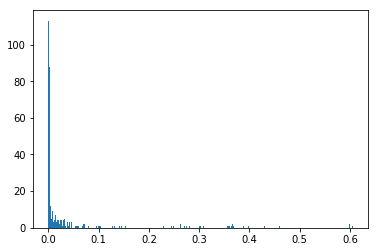

In [49]:
N_BINS = 1000
n,bins,_ = plt.hist(np.concatenate([y_speedups_train,y_speedups_test]),bins=N_BINS)
bin_size = 0
for i in range(bins.shape[0]-1):
    #print "Bin [{} - {}] => Num elements {}".format(bins[i],bins[i+1],n[i])
    bin_size += bins[i+1]-bins[i]

bin_size /= (bins.shape[0]-1)

y_sp_train_class = []
y_sp_test_class = []


for spdup in y_speedups_train:
    found=False
    for i in range(bins.shape[0]-1):
        if spdup >= bins[i]-1e-4 and spdup <= bins[i+1]+1e-4:
            y_sp_train_class.append(i)
            found=True
            break
    assert found,spdup

for spdup in y_speedups_test:
    found=False
    for i in range(bins.shape[0]-1):
        if spdup >= bins[i]-1e-4 and spdup <= bins[i+1]+1e-4:
            y_sp_test_class.append(i)
            found=True
            break
    assert found,spdup
    
y_sp_train_class = np.array(y_sp_train_class)
y_sp_test_class = np.array(y_sp_test_class)


# Support Vector Machine (Classification)

In [50]:
from sklearn.svm import SVC

In [51]:
model = SVC(C=200,kernel='rbf')
model.fit(x_train,y_sp_train_class)

SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [52]:
y_pred = model.predict(x_test)

In [53]:
print "Percentage Accuracy - ", 100*np.sum(y_pred==y_sp_test_class)/len(y_pred)
print "Mean absolute error - ", bin_size*np.mean(np.abs(y_pred-y_sp_test_class))
print "Mean absolute binning error - ", np.mean(np.abs(y_pred-y_sp_test_class))
print "Mean relative binning error - ", np.mean(np.abs(y_pred-y_sp_test_class)/(y_sp_test_class+1))
time_preds = np.array([0.5*(bins[y_pred[i]+1]+bins[y_pred[i]])*y_test[i,var2] for i in range(len(y_pred))])
time_act = y_test[:,var1]
print "Mean error in time pred - ",100*np.mean(np.abs(time_preds-time_act)/time_act)
#print np.abs(time_act-time_preds)



Percentage Accuracy -  22
Mean absolute error -  0.040468775671702505
Mean absolute binning error -  66.87116564417178
Mean relative binning error -  0.0
Mean error in time pred -  65.98949272948762


# XGboost (Classification)

In [54]:
from xgboost import XGBClassifier

In [55]:
model = XGBClassifier(n_estimators=100,max_depth=10)
model.fit(x_train,y_sp_train_class)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [56]:
y_pred = model.predict(x_test)


/home/anirban/Tools/python/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [57]:
print "Percentage Accuracy - ", 100*np.sum(y_pred==y_sp_test_class)/len(y_pred)
print "Mean absolute error - ", bin_size*np.mean(np.abs(y_pred-y_sp_test_class))
print "Mean absolute binning error - ", np.mean(np.abs(y_pred-y_sp_test_class))
print "% Mean relative binning error - ", 100*np.mean(np.abs(y_pred-y_sp_test_class)/(y_sp_test_class+1))
time_preds = np.array([0.5*(bins[y_pred[i]+1]+bins[y_pred[i]])*y_test[i,var2] for i in range(len(y_pred))])
time_act = y_test[:,var1]
print "% error in time pred - ",100*np.mean(np.abs(time_preds-time_act)/time_act)


Percentage Accuracy -  35
Mean absolute error -  0.006564109668584406
Mean absolute binning error -  10.846625766871165
% Mean relative binning error -  1.8404907975460123
% error in time pred -  27.59880988092164


# Linear Regression

In [58]:
from sklearn.linear_model import LinearRegression as lrg

In [61]:
model = lrg()
model.fit(x_train,y_train[:,var1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
y_pred = model.predict(x_test)
print("Mean absolute error : - ", np.mean(np.abs(y_pred-y_test[:,var1])))
print("Relative error : - ",np.mean(np.abs(y_pred-y_test[:,var1])/y_speedups_test))

('Mean absolute error : - ', 0.0006954606339132166)
('Relative error : - ', 1.2667968855428564)


# Support Vector (Regression)

In [64]:
from sklearn.svm import SVR

In [85]:

model = SVR(kernel='rbf', C=0.000000005, gamma=0.1, epsilon=.1)
model.fit(x_train,y_train[:,var1])

SVR(C=5e-09, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [86]:
y_pred = model.predict(x_test)
print("Mean absolute error : - ", np.mean(np.abs(y_pred-y_test[:,var1])))
print("Relative error : - ",np.mean(np.abs(y_pred-y_test[:,var1])/y_speedups_test))

('Mean absolute error : - ', 0.12505605223875052)
('Relative error : - ', 73.32952291897392)
